## Utilities

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from src.reconstruct.main import init_config
import configargparse
from src.dataio import StarfileDataLoader
from torch.utils.data import DataLoader
from pathlib import Path
from src.cryoai import CryoAI
import torch
import plotly as ply
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from src.flow_utils import ConvexGradientLayer
from scipy.spatial.transform import Rotation


from src.loss_utils import L2LossPreFlip

def read_config_file(f):
    parser = configargparse.ArgumentParser()
    parser.add_argument('-c', '--config', required=False, is_config_file=True,
                        help='Path to config file.')
    parser.add_argument('--experiment_type', type=str, required=True,
                        choices=['train',
                                 'evaluate_encoder',
                                 'generate_synthetic'],
                        help='The experiment to run.')
    parser.add_argument('--experiment_name', type=str, default=None, required=True,
                        help='An identifier for the train run.')
    parser.add_argument('--log_dir', type=str, default='logs/',
                        help='Output directory for logging.')
    parser.add_argument('--output_starfile_dir', type=str, default='evaluation_starfiles/',
                        help='Output directory for starfiles after pose evaluation.')
    init_config(parser)
    
    config = parser.parse_args(['-c', f])
    config.map_shape = [config.side_len] * 3
    if config.warm_start_volume or config.warm_start_full:
        assert config.path_to_warm_start is not None, "path_to_warm_start cannot be None."
    if config.use_frequency_marcher:
        assert config.volume_representation == 'imp-fourier', "Frequency marcher can only be activated for" \
                                                              " imp-fourier representation."
    if config.encoder_type == 'e2cnn':
        assert config.so3_parameterization in ['euler'], "e2cnn encoder can only be used with euler" \
                                                         " parameterization of SO(3)"
    if config.data_loss_norm == 'symloss':
        config.flip_images = 1
    if config.mask_rad > 1e-3:
        assert config.mask_rad >= config.mask_rad_loss, "The mask on the loss must be smaller than" \
                                                        " the mask on the input images"
    return config

/workspace/cryoAI/src/training_chunks.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [196]:
num_epochs = lambda ckpt_path: max([int(x.stem.split('_')[-1]) for x in ckpt_path.glob('model_epoch_*')])
def load_ckpt(ckpt_path, config, idx):
    if idx < 0:
        idx = num_epochs(ckpt_path) + idx + 1
    M = CryoAI(config)
    M.load_state_dict(torch.load(ckpt_path / f'model_epoch_{str(idx).zfill(4)}.pth', map_location='cpu'))
    return M

def to_cuda(d):
    return {k: v.cuda() if (type(v) != list) else v for k, v in d.items()}

def get_params(M, batch, idx=None, return_chosen=False):
    loss = L2LossPreFlip(
        'proj',
        mask=config.use_masked_loss,
        hf_increase=False,
        mask_rad=config.mask_rad_loss
    )

    batch = to_cuda(batch)
    res = M(batch)
    loss(res)
    # print(res['activated_paths'])

    idx_chosen = (res['activated_paths'].squeeze().item() % 2) if idx is None else idx
    params = res['latent_code_prerot'][idx_chosen].detach()
    params = ConvexGradientLayer.process_params(params[None])
    if return_chosen:
        return params, idx_chosen
    return params

In [5]:
import torch
import torch.fft
import mrcfile
import starfile
from torch.utils.data import Dataset
import torchvision.transforms.functional as tvf
import numpy as np
import os
from src.geom_utils import euler_angles2matrix
from src.ctf_utils import primal_to_fourier_2D, primal_to_fourier_3D, fourier_to_primal_2D
from src.mask_utils import Mask
from src.volume_utils import shift_coords
from pytorch3d.transforms import random_rotations
from src.dataio import DensityMapProjectionSimulator 

def get_power(vol):
    return(np.sum(np.abs(vol)))

In [7]:
mrc_filepath = 'mrcfiles/spliceosome.mrc'
projection_sz = 128
power_signal = 0.1
resolution = 4.33

class MRCProjector:
    def __init__(self, mrc_filepath, projection_sz, power_signal, resolution):
        with mrcfile.open(mrc_filepath) as mrc:
            mrc_data = np.copy(mrc.data)
            power_init = get_power(mrc_data)
            mrc_data = 2e4 * power_signal * mrc_data * mrc_data.shape[0] / (power_init * projection_sz)
            voxel_size = float(mrc.voxel_size.x)
            if voxel_size < 1e-3:  # voxel_size = 0.
                voxel_size = resolution
                
        mrc = mrc_data
        vol = torch.from_numpy(mrc).float()
        self.vol = vol
        fvol_cpx = primal_to_fourier_3D(vol)  # S, S, S
        self.fvol = torch.cat([torch.real(fvol_cpx).unsqueeze(0),
                               torch.imag(fvol_cpx).unsqueeze(0)])  # 2, S, S, S

        
        x_lim = resolution * projection_sz / (voxel_size * mrc_data.shape[0])
        lincoords = torch.linspace(-x_lim, x_lim, projection_sz)  # assume square volume
        [X, Y, Z] = torch.meshgrid([lincoords, lincoords, lincoords])
        self.vol_coords = torch.stack([Y, X, Z], dim=-1).reshape(-1, 3)  # S^3, 3

        [X, Y] = torch.meshgrid([lincoords, lincoords])
        coords = torch.stack([Y, X, torch.zeros_like(X)], dim=-1)
        coords = shift_coords(coords, 1., 1., 0, projection_sz, projection_sz, 1)  # place DC component at (0, 0, 0)
        self.plane_coords = coords.reshape(-1, 3)
        self.projection_sz = projection_sz

    def get_proj(self, rotmat):
        rot_plane_coords = torch.einsum('n i , ... i j -> ... n j', self.plane_coords.to(rotmat.device), rotmat).reshape(-1, 3)
        # rot_plane_coords = torch.matmul(self.plane_coords, rotmat)  # S^2, 3
        rot_plane_coords = shift_coords(rot_plane_coords, 1., 1., 1., self.projection_sz,
                                        self.projection_sz,
                                        self.projection_sz,
                                        flip=True)
        fplane = torch.nn.functional.grid_sample(self.fvol[None, :, :, :, :].to(rotmat.device),  # B, 2, S, S, S
                                                  rot_plane_coords[None, None, None, :, :],
                                                  align_corners=True)
        
        fplane = fplane.reshape(2, *rotmat.shape[:-2], self.projection_sz, self.projection_sz).movedim(0, -1)
        fplane = fplane.contiguous()
        fproj = torch.view_as_complex(fplane)
        proj = torch.real(fourier_to_primal_2D(fproj))
        return proj

    def get_proj2(self, rotmat):
        rot_vol_coords = torch.einsum('n i , ... i j -> ... n j', self.vol_coords, rotmat).reshape(-1, 3)
        ''' Generate proj '''
        rot_vol = torch.nn.functional.grid_sample(self.vol[None, None, :, :, :],  # B, 1, S, S, S
                                                  rot_vol_coords[None, None, None, :, :],
                                                  align_corners=True)
        proj = torch.sum(rot_vol.reshape(*rotmat.shape[:-2], *(self.projection_sz,)*3),  dim=-1)
        return proj
        
projector = MRCProjector(mrc_filepath, projection_sz, power_signal, resolution)

/venv/main/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [252]:
from tqdm import tqdm
def encode(M, proj_):
    if M.gaussian_pyramid:
        proj = M.gaussian_filters(proj_)
    latent_code = torch.flatten(M.cnn_encoder(proj), start_dim=1)
    latent_code_pose = M.orientation_encoder(latent_code)
    latent_code_prerot = M.orientation_regressor(latent_code_pose)
    pred_rotmat = M.latent_to_rot3d_fn(latent_code_prerot)
    return pred_rotmat
    
def smooth_quaternion_path(p):
    # new_path = p[[0]]
    # for pp in p[1:]:
    #     sign = ((new_path[-1] - pp).square().mean() < (new_path[-1] + pp).square().mean()) * 2 - 1
    #     new_path = torch.cat([new_path, sign * pp[None]], axis=0)
    # return new_path

    # slightly more efficient vectorized method
    p_tot = torch.stack([p, -p], dim=0)
    dists_idx = (p_tot - p.roll(1, 0)).square().mean(axis=-1).argmin(dim=0)
    return (1 - 2*(dists_idx.cumsum(dim=0) % 2))[:, None] * p

def path_continuity(p):
    p_tot = torch.stack([p, -p], dim=0)
    dists = (p_tot - p.roll(1, 0)).square().mean(axis=-1).amin(dim=0)
    return dists.max() / dists.quantile(0.9)

check_degree = lambda path: ((path[0] + path[-1]).square().mean() < (path[0] - path[-1]).square().mean()).int()

def check_model_degree(M, batch):
    with torch.no_grad():
        pred_rotmats = encode(M, batch)
    if M.use_prob:
        pred_rotmats, _ = pred_rotmats
    smoothed_path = smooth_quaternion_path(matrix_to_quaternion(pred_rotmats[:len(batch)]))
    return check_degree(smoothed_path)

def get_model_with_degree(config, degree=0):
    while True:
        M = CryoAI(config)
        M.cuda();
        if (check_model_degree(M, batch) == degree):
            break
    return M

from itertools import chain
from pytorch3d.transforms import matrix_to_euler_angles, euler_angles_to_matrix
from einops import rearrange
def train(M, batch, epochs=300, lr=1e-4, beta=1e-5):    
    optimizer = torch.optim.Adam(chain(M.cnn_encoder.parameters(), M.orientation_encoder.parameters(), M.orientation_regressor.parameters()), lr=lr)
    torch.cuda.empty_cache()
    epoch_metrics = []
    for _ in (pbar := tqdm(range(epochs + 1))):
        optimizer.zero_grad()
        pred_rotmats = encode(M, batch)

        if M.use_prob:
            pred_rotmats, prob = pred_rotmats
        else:
            prob = torch.zeros(pred_rotmats.shape[0]).to(batch)

        if M.config.flip_images:
            # pred_rotmats_tot = rearrange(pred_rotmats, '(k b) ... -> k b ...', k=2)
            angles = matrix_to_euler_angles(pred_rotmats[len(batch):], 'ZYZ') + torch.tensor([torch.pi, 0, 0]).to(batch.device)
            pred_rotmats_tot = torch.stack([pred_rotmats[:len(batch)], euler_angles_to_matrix(angles, 'ZYZ')], axis=0)
            tot_pred = projector.get_proj(pred_rotmats_tot)
            loss = (tot_pred - batch[:, 0]).square().mean(axis=(-1, -2)) # 2 B
            min_idxs = loss.argmin(dim=0)
            pred_rotmats = pred_rotmats_tot[min_idxs, torch.arange(pred_rotmats_tot.shape[1])]
            prob = prob.reshape(2, -1)[min_idxs, torch.arange(loss.shape[1])]
            loss = loss[min_idxs, torch.arange(loss.shape[1])].mean()
        else:
            loss = (projector.get_proj(pred_rotmats[:len(batch)]) - projections.cuda()).square().mean()
            prob = prob[:len(batch)]
        
        loss = loss + beta * prob.mean()

        with torch.no_grad():
            smoothed_path = smooth_quaternion_path(matrix_to_quaternion(pred_rotmats[:len(batch)]))
            degree = check_degree(smoothed_path)

        metrics = {'loss': loss.detach().cpu(), 'degree': degree.detach().cpu(), 'continuity': path_continuity(smoothed_path).detach().cpu(), 'path': smoothed_path.detach().cpu()} 
        
        loss.backward()
        optimizer.step()
    
        pbar.set_description(f'loss={metrics['loss']:.2e} degree={metrics['degree']} continuity={metrics['continuity']:.2e}')
        epoch_metrics.append(metrics)        
    return epoch_metrics

def train_to_target(M, batch, target_rots, epochs=300, lr=1e-4, beta=1e-5):    
    optimizer = torch.optim.Adam(chain(M.cnn_encoder.parameters(), M.orientation_encoder.parameters(), M.orientation_regressor.parameters()), lr=lr)
    torch.cuda.empty_cache()
    for _ in (pbar := tqdm(range(epochs))):
        optimizer.zero_grad()
        pred_rotmats = encode(M, batch)

        if M.use_prob:
            pred_rotmats, prob = pred_rotmats
        else:
            prob = torch.zeros(pred_rotmats.shape[0]).to(batch)

        if M.config.flip_images:
            # pred_rotmats_tot = rearrange(pred_rotmats, '(k b) ... -> k b ...', k=2)
            angles = matrix_to_euler_angles(pred_rotmats[len(batch):], 'ZYZ') + torch.tensor([torch.pi, 0, 0]).to(batch.device)
            pred_rotmats_tot = torch.stack([pred_rotmats[:len(batch)], euler_angles_to_matrix(angles, 'ZYZ')], axis=0)
            # tot_pred = projector.get_proj(pred_rotmats_tot)
            # loss = (tot_pred - batch[:, 0]).square().mean(axis=(-1, -2)) # 2 B
            loss = (pred_rotmats_tot - target_rots).square().mean(axis=(-1, -2))
            min_idxs = loss.argmin(dim=0)
            pred_rotmats = pred_rotmats_tot[min_idxs, torch.arange(pred_rotmats_tot.shape[1])]
            prob = prob.reshape(2, -1)[min_idxs, torch.arange(loss.shape[1])]
            loss = loss[min_idxs, torch.arange(loss.shape[1])].mean()
        else:
            # loss = (projector.get_proj(pred_rotmats[:len(batch)]) - projections.cuda()).square().mean()
            loss = (pred_rotmats - target_rots).square().mean()
            prob = prob[:len(batch)]
        
        loss = loss + beta * prob.mean()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            smoothed_path = smooth_quaternion_path(matrix_to_quaternion(pred_rotmats[:len(batch)]))
            degree = check_degree(smoothed_path)

        metrics = {'loss': loss.detach().cpu(), 'degree': degree.detach().cpu(), 'continuity': path_continuity(smoothed_path).detach().cpu()} 
        pbar.set_description(f'loss={metrics['loss']:.2e} degree={metrics['degree']} continuity={metrics['continuity']:.2e}')
    return metrics['continuity'] < 10

def plot_quaternion_path(path, pca_v=None, ax=None):
    ps = quaternion_to_axis_angle(path)
    ax = plt.gca() if ax is None else ax
    pca_v = torch.linalg.eigh(ps.T @ ps).eigenvectors[:, -2:] if pca_v is None else pca_v
    l, = ax.plot(*(ps @ pca_v).T, '-')
    l, = ax.plot(*(ps[::8] @ pca_v).T, 'o', color=l.get_color())
    
    ax.set_aspect('equal')
    ax.set_xlim(-np.pi*1.1, np.pi*1.1)
    ax.set_ylim(-np.pi*1.1, np.pi*1.1)
    
    theta = np.linspace(-np.pi, np.pi, 128)
    ax.plot(np.cos(theta)*np.pi, np.sin(theta)*np.pi)

def run_trials_random(config, batch, num_trials=16, out_dir=None, **kwargs):
    metrics = []
    for _ in range(16):
        M = get_model_with_degree(config, degree=0)
        metrics_trial = train(M, batch, **kwargs);
        metrics.append(metrics_trial)
    if out_dir is not None:
        torch.save(metrics, out_dir)
    return metrics


In [253]:
torch.manual_seed(42) ## for reproducibility

## Topological Defects at Initialization

In [254]:
from pytorch3d.transforms import axis_angle_to_matrix, axis_angle_to_quaternion, quaternion_to_matrix, matrix_to_quaternion
axis = torch.randn(1, 3)
axis[..., -1] *= 0.1
axis /= axis.norm(dim=-1, keepdim=True)
nontrivial_loop = axis_angle_to_matrix(axis * torch.linspace(-torch.pi, torch.pi, 128)[:-1, None])
projections = projector.get_proj(nontrivial_loop)
batch = projections[:, None].cuda()

In [255]:
axis

tensor([[0.9320, 0.3566, 0.0649]])

In [256]:
path = smooth_quaternion_path(matrix_to_quaternion(nontrivial_loop))
check_degree(path), path_continuity(path)

(tensor(1, dtype=torch.int32), tensor(1.0000))

In [ ]:
config_mode = read_config_file('configfiles/train_spliceosome_mode.ini')
run_trials_random(config_mode, batch, epochs=150, beta=0, out_dir='results/degree_obs/mode_nobeta.pt');

loss=4.66e-02 degree=0 continuity=5.77e+00:   5%|▍         | 7/151 [00:01<00:33,  4.31it/s]

In [ ]:
config_mode = read_config_file('configfiles/train_spliceosome_mode.ini')
run_trials_random(config_mode, batch, epochs=150, beta=3e-5, out_dir='results/degree_obs/mode_beta.pt');

In [ ]:
config_cryo = read_config_file('configfiles/train_spliceosome.ini')
run_trials_random(config_cryo, batch, epochs=150, out_dir='results/degree_obs/cryo.pt');

In [212]:
config_mode = read_config_file('configfiles/train_spliceosome_mode.ini')
metrics_mode_runs = []
for _ in range(16):
    M = get_model_with_sign(config_mode)
    metrics_mode = train(M, batch, beta=0, epochs=100);
    metrics_mode_runs.append(metrics_mode)
torch.save(metrics_mode_runs, 'results/degree_obs/mode_nobeta.pt')

config_mode = read_config_file('configfiles/train_spliceosome_mode.ini')
metrics_mode_runs = []
for _ in range(16):
    M = get_model_with_sign(config_mode)
    metrics_mode = train(M, batch, beta=3e-5, epochs=100);
    metrics_mode_runs.append(metrics_mode)
torch.save(metrics_mode_runs, 'results/degree_obs/mode_nobeta.pt')

config_cryoai = read_config_file('configfiles/train_spliceosome.ini')
metrics_cryoai_runs = []
for _ in range(16):
    M = get_model_with_sign(config_cryoai)
    metrics_cryoai = train(M, batch, epochs=100);
    metrics_cryoai_runs.append(metrics_cryoai)
torch.save(metrics_cryoai_runs, 'results/degree_obs/cryoai.pt')

loss=9.62e-04 degree=1 continuity=1.71e+00: 100%|██████████| 101/101 [00:22<00:00,  4.54it/s]


In [215]:
torch.tensor([m[-1]['continuity'] < 10 for m in metrics_cryoai_runs]).float().sum()

tensor(8.)

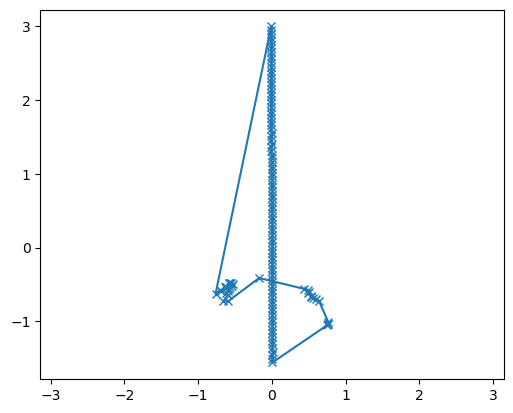

In [92]:
from pytorch3d.transforms import matrix_to_axis_angle, quaternion_to_matrix
quaternion_to_axis_angle = lambda x: matrix_to_axis_angle(quaternion_to_matrix(x))
ps = quaternion_to_axis_angle(metrics_cryoai_runs[-6][-1]['path'])

pca_v = torch.linalg.eigh(ps.T @ ps).eigenvectors[:, -2:]
plt.plot(*(ps @ pca_v).T, 'x-')
plt.gca().set_xlim(-np.pi, np.pi)
plt.gca().set_xlim(-np.pi, np.pi)
plt.gca().set_aspect('equal')


## Forced Topological Defects via Adversarial Training

In [129]:
from pytorch3d.transforms import axis_angle_to_matrix, axis_angle_to_quaternion, quaternion_to_matrix, matrix_to_quaternion
from pytorch3d.transforms import matrix_to_axis_angle, quaternion_to_matrix
from pytorch3d.transforms import quaternion_to_axis_angle as quaternion_to_axis_angle_
quaternion_to_axis_angle = lambda x: (v := quaternion_to_axis_angle_(x)) / v.norm(dim=-1, keepdim=True) * ((v.norm(dim=-1, keepdim=True) + torch.pi) % (2 * torch.pi) - torch.pi)

axis = torch.randn(1, 3)
axis[..., -1] *= 0.1
axis /= axis.norm(dim=-1, keepdim=True)
nontrivial_loop = axis_angle_to_matrix(axis * torch.linspace(-torch.pi, torch.pi, 128)[:-1, None])
projections = projector.get_proj(nontrivial_loop)
batch = projections[:, None].cuda()

In [234]:
from src.flow_utils import orthogonal
o1 = orthogonal(axis)[0][0]
trivial_loop = axis_angle_to_matrix(torch.einsum('b i j, ... j -> b i', axis_angle_to_matrix(o1 * torch.linspace(-torch.pi, torch.pi, 128)[:-1, None]), axis))

In [236]:
path = smooth_quaternion_path(matrix_to_quaternion(trivial_loop))
check_degree(path), path_continuity(path)

(tensor(0, dtype=torch.int32), tensor(1.0000))

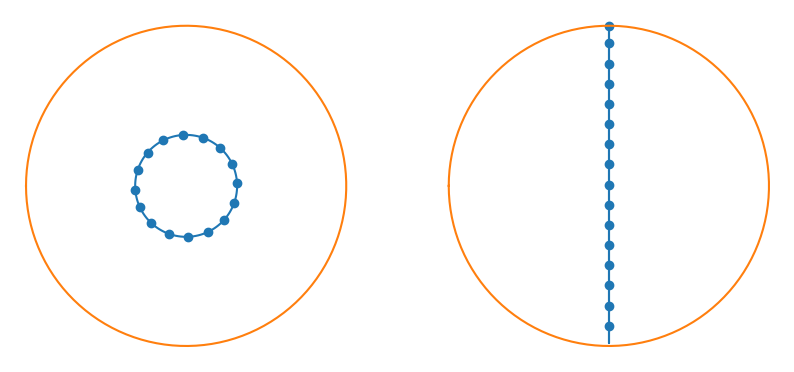

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_quaternion_path(matrix_to_quaternion(trivial_loop), ax=axs[0])
plot_quaternion_path(matrix_to_quaternion(nontrivial_loop), ax=axs[1])

[ax.axis('off') for ax in axs]
plt.savefig('loop_classes.png', bbox_inches='tight')

In [191]:
config_mode2 = read_config_file('configfiles/train_spliceosome_vae2.ini')
metrics_mode2_runs = []
for _ in range(16):
    M = CryoAI(config_mode2)
    M.cuda();
    train_to_target(M, batch, trivial_loop.cuda(), epochs=50, beta=0)
    metrics_mode = train(M, batch, beta=0, epochs=150);
    metrics_mode2_runs.append(metrics_mode)
torch.save(metrics_mode_runs, 'results/degree_obs/mode_nobeta_adv.pt')

loss=9.30e-03 degree=0 continuity=1.28e+03: 100%|██████████| 151/151 [00:37<00:00,  3.98it/s]


In [192]:
config_mode = read_config_file('configfiles/train_spliceosome_vae2.ini')
metrics_mode_runs = []
for _ in range(16):
    M = CryoAI(config_mode)
    M.cuda();
    train_to_target(M, batch, trivial_loop.cuda(), epochs=50, beta=0)
    metrics_mode = train(M, batch, beta=3e-5, epochs=150);
    metrics_mode_runs.append(metrics_mode)
torch.save(metrics_mode_runs, 'results/degree_obs/mode_beta_adv.pt')

loss=5.36e-04 degree=1 continuity=1.72e+00: 100%|██████████| 151/151 [00:37<00:00,  3.99it/s]


In [193]:
config_cryoai = read_config_file('configfiles/train_spliceosome.ini')
metrics_cryoai_runs = []
for _ in range(16):
    M = CryoAI(config_cryoai)
    M.cuda();
    train_to_target(M, batch, trivial_loop.cuda(), epochs=50)
    metrics = train(M, batch, epochs=150);
    metrics_cryoai_runs.append(metrics)
torch.save(metrics_cryoai_runs, 'results/degree_obs/cryoai_adv.pt')

loss=8.53e-05 degree=1 continuity=1.08e+00: 100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


In [195]:
config_cryoai = read_config_file('configfiles/train_spliceosome.ini')
config_cryoai.flip_images = False
metrics_cryoai_noflip_runs = []
for _ in range(16):
    while True:
        M = CryoAI(config_cryoai)
        M.cuda();
        if train_to_target(M, batch, trivial_loop.cuda(), epochs=50, lr=1e-4):
            break
        
    metrics = train(M, batch, epochs=150);
    metrics_cryoai_noflip_runs.append(metrics)

torch.save(metrics_cryoai_noflip_runs, 'results/degree_obs/cryoai_adv_nosym.pt')

loss=8.63e-03 degree=0 continuity=2.44e+03: 100%|██████████| 151/151 [00:19<00:00,  7.89it/s]


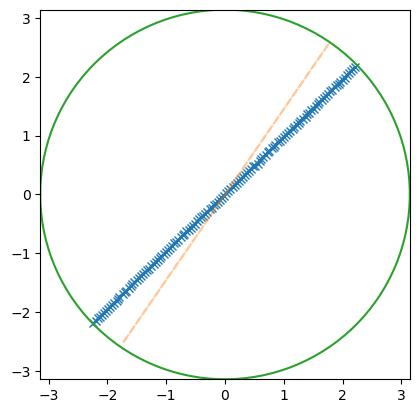

In [190]:
# metrics_cryoai_runs = torch.load('cryoai_adv.pt')

def animate_run(run):
    ps = quaternion_to_axis_angle(run[0]['path'])
    pca_v = torch.linalg.eigh(ps.T @ ps).eigenvectors[:, -2:]
    nontrivial_axis = matrix_to_axis_angle(nontrivial_loop)
    
    fig, ax = plt.subplots()
    l, = ax.plot(*(ps @ pca_v).T, 'x-')
    ax.plot(*(nontrivial_axis @ pca_v).T, '--', alpha=0.4)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_aspect('equal')
    
    theta = np.linspace(-np.pi, np.pi, 128)
    ax.plot(np.cos(theta)*np.pi, np.sin(theta)*np.pi)
    
    def animate(i):
        ps = quaternion_to_axis_angle(run[i]['path'])
        l.set_data(*(ps @ pca_v).T)
        
    from matplotlib.animation import FuncAnimation
    ani = FuncAnimation(fig, animate, frames=len(run))
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

animate_run(metrics_mode2_runs[0])

## Resolution of Topological Defects during Normal Training

In [44]:
torch.cuda.memory._dump_snapshot("snapshot.pickle")

In [53]:
torch.cuda.empty_cache()

In [54]:
config = read_config_file('configfiles/train_spliceosome_vae2.ini')
ckpt_path = Path('logs/long_2') / 'models' / 'checkpoints'
M = load_ckpt(ckpt_path, config, 2)
M = M.cuda();

In [55]:
from pytorch3d.transforms import axis_angle_to_matrix, axis_angle_to_quaternion, quaternion_to_matrix, matrix_to_quaternion
axis = torch.randn(1, 3)
# axis[..., -1] *= 0.1
axis /= axis.norm(dim=-1, keepdim=True)
nontrivial_loop = axis_angle_to_matrix(axis * torch.linspace(-torch.pi, torch.pi, 128)[:-1, None])
projections = projector.get_proj(nontrivial_loop)
batch = projections[:, None].cuda()

pred_rotmats = encode(M, batch)[0]
angles = matrix_to_euler_angles(pred_rotmats[len(batch):], 'ZYZ') + torch.tensor([torch.pi, 0, 0]).to(batch.device)
pred_rotmats_tot = torch.stack([pred_rotmats[:len(batch)], euler_angles_to_matrix(angles, 'ZYZ')], axis=0)
tot_pred = projector.get_proj(pred_rotmats_tot)
loss = (tot_pred - batch[:, 0]).square().mean(axis=(-1, -2)) # 2 B
min_idxs = loss.argmin(dim=0)
pred_rotmats = pred_rotmats_tot[min_idxs, torch.arange(pred_rotmats_tot.shape[1])]
loss = loss[min_idxs, torch.arange(loss.shape[1])].mean()

path = smooth_quaternion_path(matrix_to_quaternion(pred_rotmats))
check_sign(path[-1], path[0])

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacity of 47.38 GiB of which 50.69 MiB is free. Including non-PyTorch memory, this process has 47.31 GiB memory in use. Of the allocated memory 46.72 GiB is allocated by PyTorch, and 126.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)